100%|██████████| 172/172 [08:20<00:00,  2.91s/it]


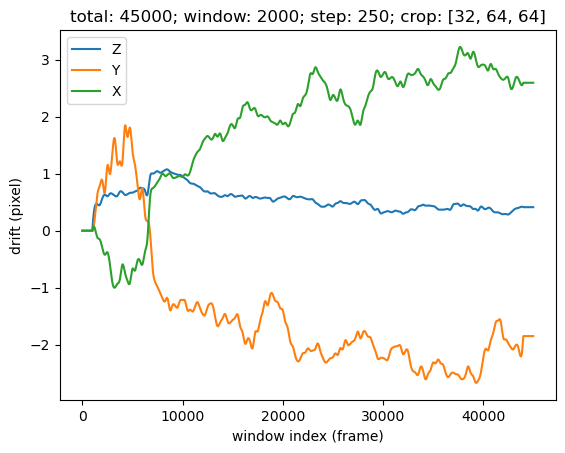

In [1]:
from sml import DriftCorrector

corrector = DriftCorrector(
    total=45000, window=2000, step=250, crop=[32, 64, 64]
).fit()

In [ ]:
""" frame preprocess
Convert the Xunamen output 
from (64 512 512)pixel ( 65 130 130)nm 16bit
to   (32 512 512)pixel (130 130 130)nm 16bit
To save storage space.
"""

import torch
import torch.nn.functional as F
import numpy as np
import os
import tifffile
import tqdm

frames_load_fold = "E:/frames"
frames_save_fold = "D:/frames"

frames_list = os.listdir(frames_load_fold)
for index in tqdm.tqdm(range(len(frames_list))):
    # read 16 bit tiff, note that the order of os.listdir is not guaranteed
    frame = tifffile.imread(
        os.path.join(frames_load_fold, frames_list[index])
    ).astype(np.float32)
    frame = torch.from_numpy(frame).float()
    # 64 512 512 -> 32 512 512
    frame = F.interpolate(
        frame.unsqueeze(0).unsqueeze(0), 
        size = (32, 512, 512)
    ).squeeze(0).squeeze(0).half()
    # save 16 bit with file name formation
    tifffile.imwrite(
        "{}/{:05}.tif".format(frames_save_fold, int(frames_list[index][11:-4])),
        frame.numpy()
    )

In [ ]:
""" mlist preprocess
(x, y, z, FWHM_x, FWHM_y, FWHM_z, peak) -> (z, x, y, var_z, var_x, var_y, peak)
x, y, z start index from 1 to 0, i.e., 1-64 to 0-63
z pixel size from 65 to 130, (64, 512, 512) -> (32, 512, 512)
"""

import torch
import os
import h5py
import scipy.io
import tqdm

mlists_load_fold = "D:/hela/coords_20231003"
mlists_save_fold = "D:/hela/mlists"

mlists_list = os.listdir(mlists_load_fold)
for index in tqdm.tqdm(range(len(mlists_list))):
    # read mlist
    try:
        with h5py.File(
            os.path.join(mlists_load_fold, mlists_list[index]), 'r'
        ) as file: mlist = file['storm_coords'][()].T
    except OSError:
        _, mlist = scipy.io.loadmat(
            os.path.join(mlists_load_fold, mlists_list[index])
        ).popitem()
    mlist = torch.from_numpy(mlist).float()

    # (x, y, z, FWHM_x, FWHM_y, FWHM_z, peak) -> 
    # (z, x, y, FWHM_z, FWHM_x, FWHM_y, peak)
    mlist = mlist[:, [2, 0, 1, 5, 3, 4, 6]]
    # index from (0 - 64) to (-0.5 - 63.5)
    mlist[:, 0:3] = mlist[:, 0:3] - 0.5
    # (65, 130, 130)nm -> (130, 130, 130)nm
    mlist[:, 0] = (mlist[:, 0] + 0.5) / 2 - 0.5
    mlist[:, 3] =  mlist[:, 3] / 2
    # (x, y, z, FWHM_x, FWHM_y, FWHM_z, peak) -> 
    # (z, x, y, var_z, var_x, var_y, peak)
    mlist[:, 3:6] = (mlist[:, 3:6] / 2.355) ** 2

    # save
    scipy.io.savemat(
        "{}/{:05}.mat".format(mlists_save_fold, int(mlists_list[index][11:-4])),
        {"storm_coords": mlist.numpy()}
    )

In [ ]:
""" mlist2label
Generating Frames using mlist from traditional method
"""

import torch
import torch.nn.functional as F
from torch import Tensor
import os
import tifffile
import h5py
import scipy.io
import tqdm

# dimensional config
dim_frame = Tensor([ 32, 512, 512]).int()   # (C, H, W), (130, 130, 130)nm
up_sample = Tensor([  4,   8,   8]).int()   # (C, H, W)
dim_label = dim_frame * up_sample
# data path
frames_load_fold = "D:/hela/frames"
mlists_load_fold = "D:/hela/mlists"
data_save_fold   = "D:/temp"

# file name list
frames_list = os.listdir(frames_load_fold)
mlists_list = os.listdir(mlists_load_fold)

# create folder
if not os.path.exists(data_save_fold): os.makedirs(data_save_fold)

result = torch.zeros(*dim_label.tolist())
for index in tqdm.tqdm(
    range(len(frames_list)), desc=data_save_fold, unit="frame"
):
    mlist = None
    try:
        with h5py.File(os.path.join(
            mlists_load_fold, mlists_list[index]
        ), 'r') as file: mlist = file['storm_coords'][()].T
    except OSError:
        _, mlist = scipy.io.loadmat(
            os.path.join(mlists_load_fold, mlists_list[index])
        ).popitem()
    mlist = torch.from_numpy(mlist).float()

    mlist[:, 0:3]  = (mlist[:, 0:3] + 0.5) * up_sample - 0.5
    mlist[:, 0:3]  = torch.round(mlist[:, 0:3])
    mlist[:, 0:3]  = torch.clip(mlist[:, 0:3], torch.zeros_like(dim_label), dim_label - 1)
    mlist[:,   6] /= 6.5

    # label
    for i in range(mlist.shape[0]):
        mean = mlist[i, 0:3]
        peak = torch.clip(mlist[i, 6], 0, 1)
        result[tuple(mean.int())] += peak

    # save after combine 1, 2, 4, 8, 16... frames
    current_frame = index + 1
    if current_frame & (current_frame - 1) == 0 or index == 45000 - 1:
        tifffile.imwrite(
            "{}/{:05}.tif".format(data_save_fold, current_frame),
            result.numpy()
        )

In [ ]:
""" resolution
Measure the resolution by cluster.
"""

import numpy as np
from sklearn.mixture import GaussianMixture
import scipy.io
import os
import tqdm
from typing import List

def get_cluster_mlist(
    clsuter_list: np.ndarray, wide: int, mlists_load_fold: str
) -> List[np.ndarray]:
    # file name list
    mlists_list = os.listdir(mlists_load_fold)

    # use to store final result
    cluster_mlist = [[] for _ in range(len(clsuter_list))]

    # go through all mlists and get the mlist for each cluster
    for index in tqdm.tqdm(range(45000), unit="mlist"):
        # read a mlist out of 45000 mlists
        _, mlist = scipy.io.loadmat(
            os.path.join(mlists_load_fold, mlists_list[index])
        ).popitem()
        # (H W D), index start from 1 -> (D H W), index start from 0
        mlist = mlist[:, [2, 0, 1]] - 1
        # [64 512 512] -> [32 512 512]
        mlist[:, 0] = (mlist[:, 0] + 0.5) / 2 - 0.5

        for c in range(len(clsuter_list)):
            # find the submlist that match the position with current cluster
            position = clsuter_list[c]  # (D H W)
            submlist = mlist
            submlist = submlist[submlist[:, 0] >= position[0] - wide]
            submlist = submlist[submlist[:, 0] <= position[0] + wide]
            submlist = submlist[submlist[:, 1] >= position[1] - wide]
            submlist = submlist[submlist[:, 1] <= position[1] + wide]
            submlist = submlist[submlist[:, 2] >= position[2] - wide]
            submlist = submlist[submlist[:, 2] <= position[2] + wide]

            # add the molecular in submlist to cluster_mlist
            for i in range(len(submlist)): cluster_mlist[c].append(submlist[i])

    # mena center each cluster's mlist
    for k in range(len(cluster_mlist)):
        cluster_mlist[k] = np.array(cluster_mlist[k])
        if cluster_mlist[k].shape[0] == 0: continue

        gmm = GaussianMixture(n_components=1)
        gmm.fit(cluster_mlist[k])
        cluster_mlist[k] -= gmm.means_[0]

    return cluster_mlist  # [K, num of mol in each cluster]

# load cluster position
cluster_list = np.array([  # (D H W), index start from 0
    [85, 1603, 523 ],
    [88, 1437, 512 ],
    [86, 1447, 493 ],
    [51, 1546, 685 ],
    [53, 1576, 867 ],
    [57, 1768, 1110],
    [58, 1686, 1214],
    [61, 670 , 482 ],
    [59, 574 , 607 ],
    [62, 531 , 1239],
    [62, 712 , 1416],
    [61, 1059, 1671]
])
# since position in cluster_list find in super resolution image
cluster_list = (cluster_list + 0.5) / 4 - 0.5

# go through all mlists and get the mlist (mean centered) for each cluster
cluster_mlist = get_cluster_mlist(cluster_list, 0.5, "D:/mlists")

# combine all cluster's mlist and fit a gmm
all_mlist = []
for k in range(len(cluster_mlist)): all_mlist.extend(cluster_mlist[k])
gmm = GaussianMixture(n_components=1)
gmm.fit(all_mlist)

# information
print(gmm.covariances_)
print(gmm.means_)

In [ ]:
""" threshold pre process: concat threshold eval result
For each threshold, we have 17 time points 3D images.
1.  We concat them into a 4D image (T Z Y X). 
2.  Since imagej can only encode temperal (T) information into colar where we
    want to encode depth (Z) to colar, we transpose the 4D image into (Z T Y X).
3.  Finaally, we normlize all the images using the same maximum. This number can
    be set accordingly.
"""

import numpy as np
import tifffile

for s in [
    "000",
    "010", "020", "030", "040", "050", 
    "060", "070", "080", "090", "100",
]:
    # T Z Y X
    T = []
    for t in [
        1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 
        1024, 2048, 4096, 8192, 16384, 32768, 45000
    ]: T.append(tifffile.imread(
        "data/d_06/{}/outputs_{}.tif".format(s, t)
    ))

    # Z T Y X
    T = np.array(T).transpose(1, 0, 2, 3)

    # normalize
    T[T > 10.0] = 10.0

    tifffile.imwrite(
        "C:/Users/tianrui/Desktop/{}.tif".format(s),
        np.array(T), imagej=True,
        metadata={
            "unit": "nm",
            "axes": "TZYX",
        }
    )

In [ ]:
""" threshold post process: Z * (T Y X) -> (T Z Y X)
For each threshold, after we encode depth info into color, we got (T Y X) image
where in T we store 17 time points. We then combine all threshold to Z, forming
a (Z T Y X) image.
However, in imagej, the order of tiff is "TZYXS" instead of "TZYXS". So we need
to transpose the image to (T Z Y X) image. Note here "S" for color.
"""

import numpy as np
import tifffile

# Z T Y X
Z = []
for s in [
    "000",
    "010", "020", "030", "040", "050", 
    "060", "070", "080", "090", "100",
]: Z.append(tifffile.imread(
    "C:/Users/tianrui/Desktop/{}_h.tif".format(s)
))

# T Z Y X
Z = np.array(Z).transpose(1, 0, 2, 3, 4)

tifffile.imwrite(
    "C:/Users/tianrui/Desktop/threshold.tif", 
    np.array(Z), imagej=True,
    metadata={
        "unit": "nm",
        "axes": "TZYXS",
    }
)